In [58]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [59]:
data_path = '/content/drive/MyDrive/MML/seattle-weather.csv'

In [60]:
try:
    df = pd.read_csv(data_path, encoding='latin-1')
except pd.errors.ParserError as e:
    print(f"ParserError: {e}")


In [61]:
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].map(pd.Timestamp.timestamp)


In [62]:
target_column = 'weather'
label_encoder = LabelEncoder()
df[target_column] = label_encoder.fit_transform(df[target_column])

In [63]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_columns] = (df[numeric_columns] - df[numeric_columns].mean()) / df[numeric_columns].std()


In [64]:
feature_column = 'date'  # Replace with your actual feature column
target_column = 'weather'  # Replace with your actual target column


In [65]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [66]:
class CustomDataset(Dataset):
    def __init__(self, data, feature_column, target_column, sequence_length):
        self.features = data[[feature_column]].values.astype(np.float32)  # Convert to float32
        self.targets = data[target_column].values.astype(np.float32)
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.features) - self.sequence_length

    def __getitem__(self, idx):
        return (
            torch.tensor(self.features[idx:idx + self.sequence_length]).unsqueeze(1),  # Add a dimension for sequence
            torch.tensor(self.targets[idx + self.sequence_length])
        )

In [67]:
sequence_length = 10  # Adjust as needed
train_dataset = CustomDataset(train_df, feature_column, target_column, sequence_length)
test_dataset = CustomDataset(test_df, feature_column, target_column, sequence_length)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [68]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Use only the last output in the sequence
        return out

In [69]:
# Instantiate the model
input_size = 1  # Adjust based on the number of features (1 for univariate time series)
hidden_size = 128
num_layers = 2
output_size = 1  # Predicting a single value
model = RNNModel(input_size, hidden_size, num_layers, output_size)


In [70]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [76]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()

        # Verify the shape of inputs
        inputs = inputs.view(inputs.size(0), sequence_length, input_size)  # Ensure the input shape is correct
        outputs = model(inputs)

        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()

        if (i + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

Epoch [1/10], Step [10/37], Loss: 1.0421
Epoch [1/10], Step [20/37], Loss: 1.0258
Epoch [1/10], Step [30/37], Loss: 1.2228
Epoch [2/10], Step [10/37], Loss: 0.8521
Epoch [2/10], Step [20/37], Loss: 0.9076
Epoch [2/10], Step [30/37], Loss: 1.2970
Epoch [3/10], Step [10/37], Loss: 0.9916
Epoch [3/10], Step [20/37], Loss: 1.3651
Epoch [3/10], Step [30/37], Loss: 0.7297
Epoch [4/10], Step [10/37], Loss: 0.8086
Epoch [4/10], Step [20/37], Loss: 1.1880
Epoch [4/10], Step [30/37], Loss: 0.8843
Epoch [5/10], Step [10/37], Loss: 0.8484
Epoch [5/10], Step [20/37], Loss: 0.9245
Epoch [5/10], Step [30/37], Loss: 0.6183
Epoch [6/10], Step [10/37], Loss: 0.8077
Epoch [6/10], Step [20/37], Loss: 0.9620
Epoch [6/10], Step [30/37], Loss: 1.2959
Epoch [7/10], Step [10/37], Loss: 1.0259
Epoch [7/10], Step [20/37], Loss: 0.8728
Epoch [7/10], Step [30/37], Loss: 0.8444
Epoch [8/10], Step [10/37], Loss: 0.6940
Epoch [8/10], Step [20/37], Loss: 1.0216
Epoch [8/10], Step [30/37], Loss: 0.8925
Epoch [9/10], St

In [77]:
model.eval()
predicted_values = []
true_values = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.view(inputs.size(0), sequence_length, input_size)  # Ensure the input shape is correct
        outputs = model(inputs)
        predicted_values.extend(outputs.squeeze().tolist())
        true_values.extend(targets.tolist())


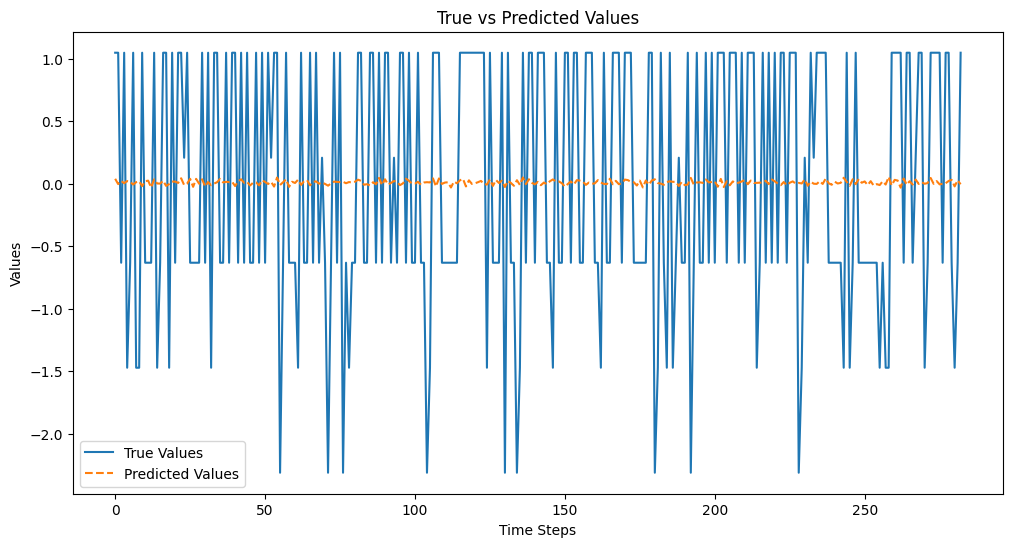

In [78]:
plt.figure(figsize=(12, 6))
plt.plot(true_values, label='True Values')
plt.plot(predicted_values, label='Predicted Values', linestyle='dashed')
plt.legend()
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.title('True vs Predicted Values')
plt.show()